In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## training set

In [2]:
train = pd.read_csv('titanic/train.csv')
# print("num records={}".format(train.shape[0]))
train.head()
# train.info()

s = train.isnull().sum()
for i, v in s.items():
    if(v != 0):
        print("{0:<20s} Non Null {1}".format(i,v))
    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Age                  Non Null 177
Cabin                Non Null 687
Embarked             Non Null 2


'PassengerId' --id
 'Ticket',  --ticket #
 'Name', 
 'Cabin' --cabin #

--yhat
'Survived', --1 for survived

--dont use
 'Fare',  -- $ paid

--use
'Pclass', --values 1 for upper,2,3 for lower
 'SibSp',  -- # of sybilings?
 'Parch',  -- 0 for nanny
'Embarked' -- S, C or Q for port of embarkation

--use, needs buckets
 'Age',  --numeric 0 to 80 ish

--use, needs dummies
  'Sex', --male or female 

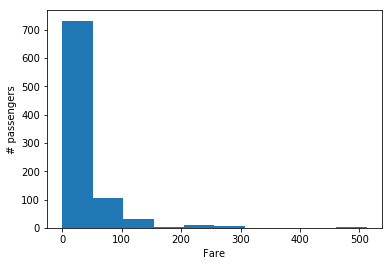

In [3]:
plt.ylabel('# passengers')
plt.xlabel('Fare')
plt.hist(train.Fare[train.Fare <= 1000].dropna());

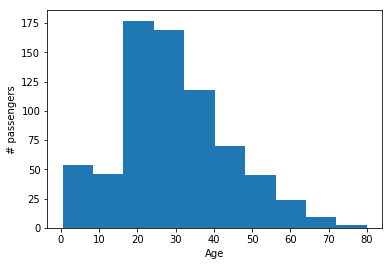

In [4]:
plt.ylabel('# passengers')
plt.xlabel('Age')
plt.hist(train.Age.dropna());

In [5]:
train1 = train.drop(['Ticket','Cabin','PassengerId'],axis=1)

train1.Embarked.fillna(train.Embarked.mode()[0], inplace=True)
train1.Age.fillna(train1.Age.mean(), inplace=True)
train1.Fare.fillna(train1.Fare.mean(), inplace=True)
train1['FamilySize'] = train1.SibSp + train1.Parch

train1['Sex'] = train.Sex.map(dict(zip(("female","male"),(0,1))))
train1["Embarked"] = train1["Embarked"].map(dict(zip(("S", "C", "Q"), (0, 1, 2))))

train1["FareCat"] = pd.cut(train1.Fare,[-1,20,40,60,80,100,200,300,800],labels=[0,1,2,3,4,5,6,7])
train1.FareCat.value_counts(dropna=False)

train1["AgeCat"] = pd.cut(train1.Age,[-1,17,25,35,45,60,100],labels=[0,1,2,3,4,5])
train1.AgeCat.value_counts(dropna=False)

train1.Sex.value_counts(dropna=False)
train1.Embarked.value_counts(dropna=False)
train1.FamilySize.value_counts(dropna=False)
# train1 = pd.get_dummies(train1,columns=['Embarked'])
train1.head()

s = train1.isnull().sum()
for i, v in s.items():
    if(v != 0):
        print("{0:<20s} Non Null {1}".format(i,v))
        
train1.info()

0    515
1    200
2     54
3     48
5     33
4     21
6     17
7      3
Name: FareCat, dtype: int64

2    373
1    188
3    114
0    113
4     81
5     22
Name: AgeCat, dtype: int64

1    577
0    314
Name: Sex, dtype: int64

0    646
1    168
2     77
Name: Embarked, dtype: int64

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,FareCat,AgeCat
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,0,1,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,1,1,3,3
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,0,0,0,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,0,1,2,2
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,0,0,0,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null int64
FamilySize    891 non-null int64
FareCat       891 non-null category
AgeCat        891 non-null category
dtypes: category(2), float64(2), int64(7), object(1)
memory usage: 72.0+ KB


In [6]:
import re
titles = list()
for row in train1["Name"]:
    surname, title, name = re.split(r"[,.]", row, maxsplit=2)
    titles.append(title.strip())
train1["Title"] = titles


for key, value in zip(("Mr", "Mrs", "Miss", "Master", "Dr", "Rev"),np.arange(6)):
    train1.loc[train1["Title"] == key, "Title"] = value
    train1.loc[train1["Title"] == "Ms", "Title"] = 1
    for title in "Major", "Col", "Capt":
        train1.loc[train1["Title"] == title, "Title"] = 6
    for title in "Mlle", "Mme":
        train1.loc[train1["Title"] == title, "Title"] = 7
    for title in "Don", "Sir":
        train1.loc[train1["Title"] == title, "Title"] = 8
    for title in "Lady","the Countess":
        train1.loc[train1["Title"] == title, "Title"] = 9

train1.loc[train1["Title"] == "Jonkheer", "Title"] = 9
train1.Title.value_counts(dropna=False)

0    517
2    182
1    126
3     40
4      7
5      6
6      5
9      3
7      3
8      2
Name: Title, dtype: int64

Accuracy: 0.776 ['Pclass', 'Sex', 'Fare', 'Title']
AxesSubplot(0.125,0.125;0.775x0.755)


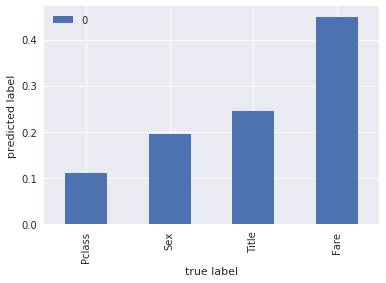

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


# from sklearn.ensemble import RandomForestClassifier

def genRf(predictors):
    X_train, X_test, y_train, y_test = train_test_split(train1[predictors], train1["Survived"])
    X_train.head()

    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test).astype('int')

    errors = abs(predictions - y_test)
#     print('Accuracy:', 1 - np.count_nonzero(errors) / errors.size)
    print("Accuracy: {0:.3f} {1}".format(1 - np.count_nonzero(errors) / errors.size, predictors))

    print(pd.DataFrame(data=rf.feature_importances_\
                 ,index=predictors).sort_values(0).plot.bar());

    mat = confusion_matrix(y_test, predictions)
#     print(sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False))
    plt.xlabel('true label')
    plt.ylabel('predicted label');


# genRf(['Pclass', 'Sex', 'AgeCat','FareCat','FamilySize','Embarked'])
# genRf(['Pclass', 'Sex', 'AgeCat','FareCat','Embarked'])
genRf(['Pclass','Sex','Fare', 'Title'])

In [9]:
train1.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,FareCat,AgeCat,Title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,0,1,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,1,1,3,3,1
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,0,0,0,2,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,0,1,2,2,1
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,0,0,0,2,0


In [17]:
# pd.scatter_matrix(train1, figsize=(30, 15))
# plt.show()
df=train1
df.corr()
# plt.matshow(df.corr())
# plt.xticks(range(len(df.columns)), df.columns)
# plt.yticks(range(len(df.columns)), df.columns)
# plt.colorbar()
# plt.show()

# looks like: Pclass,Sex,Fare, Title are most correlated

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
Survived,1.000000,-0.338481,-0.543351,-0.069809,-0.035322,0.081629,0.257307,0.106811,0.016639,0.355790
Pclass,-0.338481,1.000000,0.131900,-0.331339,0.083081,0.018443,-0.549500,0.045702,0.065997,-0.166655
Sex,-0.543351,0.131900,1.000000,0.084153,-0.114631,-0.245489,-0.182333,-0.116569,-0.200988,-0.475330
Age,-0.069809,-0.331339,0.084153,1.000000,-0.232625,-0.179191,0.091566,0.007461,-0.248512,-0.163029
SibSp,-0.035322,0.083081,-0.114631,-0.232625,1.000000,0.414838,0.159651,-0.059961,0.890712,0.209156
Parch,0.081629,0.018443,-0.245489,-0.179191,0.414838,1.000000,0.216225,-0.078665,0.783111,0.201681
Fare,0.257307,-0.549500,-0.182333,0.091566,0.159651,0.216225,1.000000,0.062142,0.217138,0.128245
Embarked,0.106811,0.045702,-0.116569,0.007461,-0.059961,-0.078665,0.062142,1.000000,-0.080281,0.117067
FamilySize,0.016639,0.065997,-0.200988,-0.248512,0.890712,0.783111,0.217138,-0.080281,1.000000,0.243707
Title,0.355790,-0.166655,-0.475330,-0.163029,0.209156,0.201681,0.128245,0.117067,0.243707,1.000000
